In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
from math import log2
def cost_basic(K: int, N: int, B: int, L: int, J: int) -> int:
    return B*N*(log2(J) + 1) + (J*L>K) * B*J*L*(log2(K) + 1)

In [44]:
df = (
    pd.read_json("out/2024-09-08/14:26:41.jsonl", lines=True)
    .drop(
        [
            "name",
            "model",
            "execution",
            "code_changes",
            "parameters",
            "model_config",
            "results",
            "count",
            "duration",
        ],
        axis=1,
    )
    .pipe(
        lambda d: d.assign(task_name=d["task"].apply(lambda x: x.get("name"))).drop(
            "task", axis=1
        )
    )
    .pipe(
        lambda d: d.join(pd.json_normalize(d["sparsity"])).drop(
            ["sparsity", "name", "reallocate_to_mean_value", "score", "rank"], axis=1
        )
    )
    .pipe(
        lambda d: d.assign(score=d["match"].combine_first(d["match_length_char"])).drop(
            ["match", "match_length_char"], axis=1
        )
    )
    .pipe(lambda d: d.assign(k=d["k"] - d["local_k"]).drop(columns="local_k"))
)
df["cost"] = df.apply(
    lambda row: cost_basic(
        row["k"],
        row["prefill_length"],
        1,
        row["k"] * row["topk_k_mult"] // row["topk_k_per_bucket"],
        row["topk_k_per_bucket"],
    ),
    axis=1,
)

In [45]:
df

,prefill_length,task_name,k,bucket_topk,topk_k_per_bucket,topk_interleaved,topk_k_mult,score,cost
0,1403.212,squad,96,False,NaN,NaN,NaN,0.800,NaN
1,1403.212,squad,96,True,96.0,False,1.0,0.800,10643.310401
2,1403.212,squad,96,True,96.0,True,1.0,0.800,10643.310401
3,1403.212,squad,96,True,32.0,False,1.0,0.798,8419.272000
4,1403.212,squad,96,True,32.0,True,1.0,0.800,8419.272000
...,...,...,...,...,...,...,...,...,...
109,1658.704,repetition,96,True,4.0,True,8.0,211.958,10801.363201
110,1658.704,repetition,96,True,2.0,False,8.0,203.322,9142.659201
111,1658.704,repetition,96,True,2.0,True,8.0,211.092,9142.659201
112,1658.704,repetition,96,True,1.0,False,8.0,157.562,7483.955201


In [46]:
df.to_json("sparq_v1.jsonl", orient="records", lines=True)

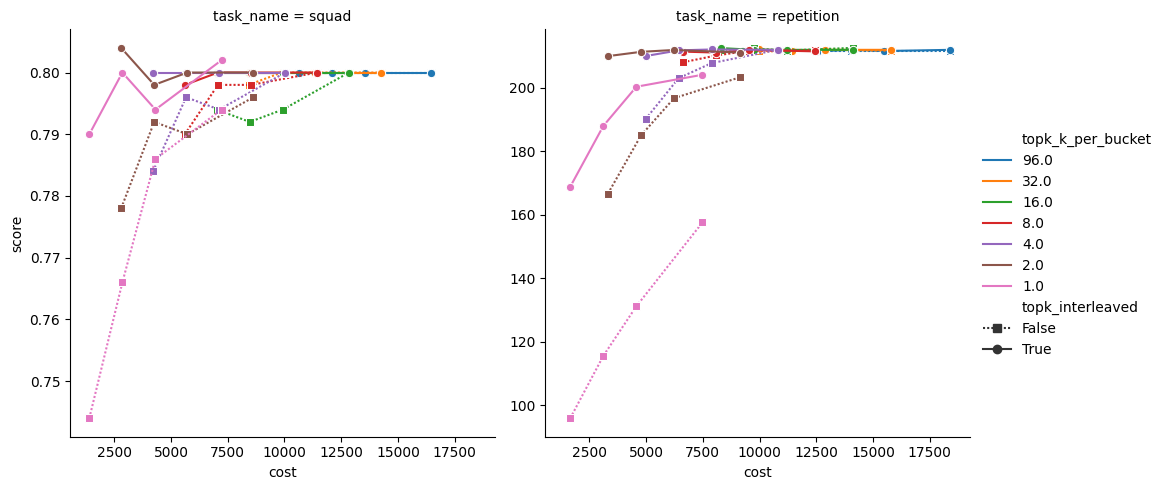

In [47]:
# Convert to categorical for seaborn
df["topk_k_per_bucket"] = df["topk_k_per_bucket"].map(lambda x: str(x))

sns.relplot(
    df[df["bucket_topk"] == True],
    x="cost",
    y="score",
    col="task_name",
    hue="topk_k_per_bucket",
    style="topk_interleaved",
    kind="line",
    dashes={True: "", False: (1, 1)},
    markers={True: "o", False: "s"},
    facet_kws=dict(sharey=False),
)
plt.show()